In [1]:
from ultralytics import YOLO
import cv2
import supervision as sv
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from supervision.metrics import MeanAveragePrecision
import numpy as np

In [2]:
model12s = YOLO("yolo12s.pt")
model12l = YOLO("yolo12l.pt")
model12m = YOLO("yolo12m.pt")

In [3]:
current_path = './images'
images = [f for f in listdir(current_path) if isfile(join(current_path, f))]
images

['1.jpg', '2.jpg', '3.jpg']

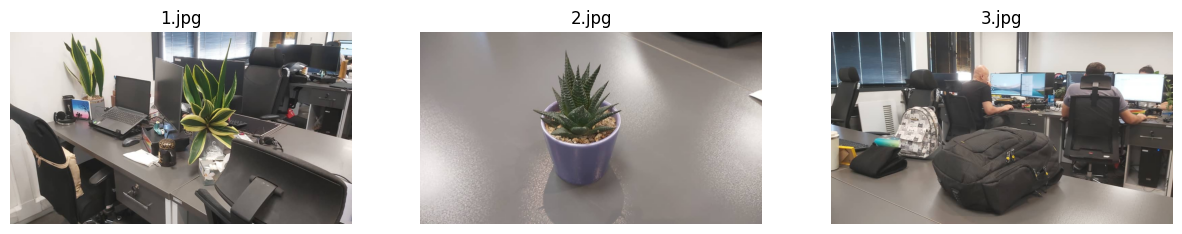

In [4]:
plt.figure(figsize=(15,5))
counter = 0
readed_images = []
for image in images:
    counter += 1
    read_image = cv2.imread(join(current_path, image))
    readed_images.append(read_image)
    img_rgb = cv2.cvtColor(read_image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, counter)
    plt.imshow(img_rgb)
    plt.title(image)
    plt.axis("off")

plt.show()

In [5]:
def create_target(detections):
    # Convert detections.xyxy (which is already np.ndarray) directly if possible
    xyxys = detections.xyxy  # Already np.ndarray with shape (N, 4)
    label_ids = detections.class_id  # np.ndarray with shape (N,)
    
    return sv.Detections(xyxy=xyxys, class_id=label_ids)

In [6]:
def calculate_map(detections):
    targets = create_target(detections)
    mean_ave = MeanAveragePrecision().update(detections, targets).compute()

    return mean_ave

In [7]:
def detection(yolo_model, readed_images, target_class_ids = None):
    detection_result = []
    mean_aves = []

    for image in readed_images:
        prediction = yolo_model(source=image)[0]
        detections = sv.Detections.from_ultralytics(prediction)

        if target_class_ids is not None:
            detections_mask = np.isin(detections.class_id, target_class_ids)
            print(detections_mask)
            detections = sv.Detections(
                xyxy=detections.xyxy[detections_mask],
                class_id=detections.class_id[detections_mask],
                confidence=detections.confidence[detections_mask],
                tracker_id=detections.tracker_id[detections_mask] if detections.tracker_id is not None else None,
                data={k: v[detections_mask] for k, v in detections.data.items()} if detections.data else None,
            )
        
        detection_result.append(detections)
        mean_ave = calculate_map(detections)
        if mean_ave is not None:
            mean_aves.append(mean_ave)
        
    return detection_result, mean_aves

In [8]:
detections_images_from_small, mean_aves_small = detection(model12s, readed_images)
detections_images_from_large, mean_aves_large = detection(model12l, readed_images)


0: 384x640 1 cup, 1 chair, 2 potted plants, 1 tv, 1 laptop, 1 mouse, 1 keyboard, 93.6ms
Speed: 2.3ms preprocess, 93.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 potted plant, 1 dining table, 71.3ms
Speed: 1.6ms preprocess, 71.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 3 backpacks, 1 handbag, 1 cup, 5 chairs, 3 tvs, 72.7ms
Speed: 1.3ms preprocess, 72.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 chairs, 2 potted plants, 2 tvs, 1 laptop, 1 mouse, 1 keyboard, 227.8ms
Speed: 1.3ms preprocess, 227.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 potted plant, 1 dining table, 1 vase, 237.8ms
Speed: 1.5ms preprocess, 237.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 backpack, 2 handbags, 4 chairs, 4 tvs, 220.6ms
Speed: 1.2ms preprocess, 220.6ms inference, 0.9ms postprocess per image at sha

In [9]:
print(mean_aves_small[0].map50_95)
print(mean_aves_large[0].map50_95)

0.9999999999999998
0.9999999999999998


In [19]:
def detector(detections_images, original_images) -> list:
    boundingBox_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_images = []

    for image, detections in zip(original_images, detections_images):
        annotated_image = boundingBox_annotator.annotate(scene=image, detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)
        annotated_images.append(annotated_image)

    return annotated_images


In [20]:
def plot_detection(annotated_images : list, image_size = 10):
    index = 1
    count = len(images)
    plt.figure(figsize=(image_size * count, 5)) 
    for annotated_image in annotated_images:
        plt.subplot(1, count, index)
        img_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(images[index -1])
        plt.tight_layout()
        plt.axis("off")
        index += 1
    
    plt.show()

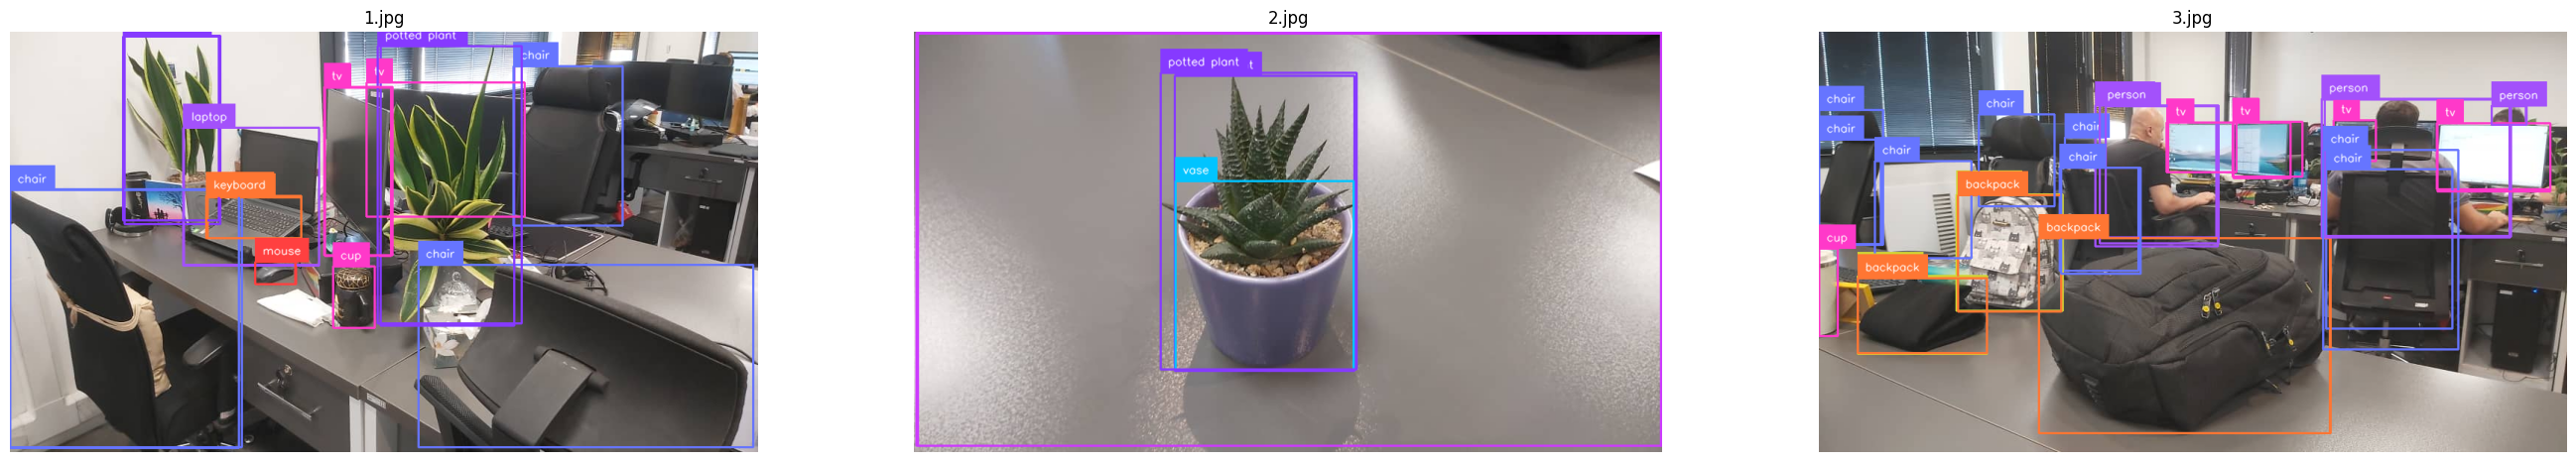

In [21]:
small = detector(detections_images_from_small, readed_images)
plot_detection(small)

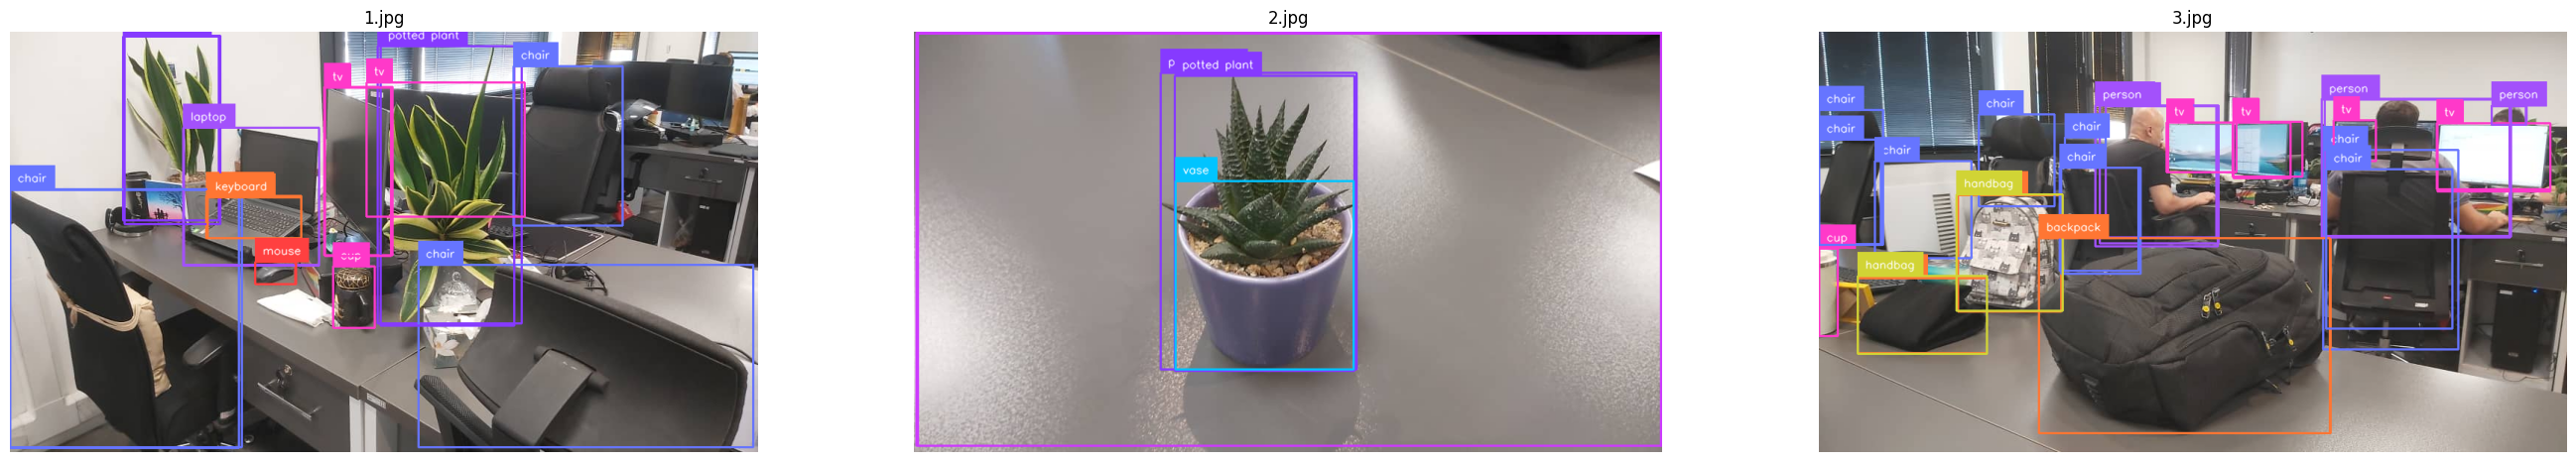

In [22]:
large = detector(detections_images_from_large, readed_images)
plot_detection(large)


0: 384x640 1 chair, 2 potted plants, 1 tv, 1 laptop, 162.4ms
Speed: 1.5ms preprocess, 162.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
[False False False False False]

0: 384x640 1 potted plant, 161.7ms
Speed: 1.5ms preprocess, 161.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
[False]

0: 384x640 2 persons, 1 backpack, 1 suitcase, 1 cup, 1 chair, 3 tvs, 158.5ms
Speed: 1.4ms preprocess, 158.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
[ True False  True False False False False False False]


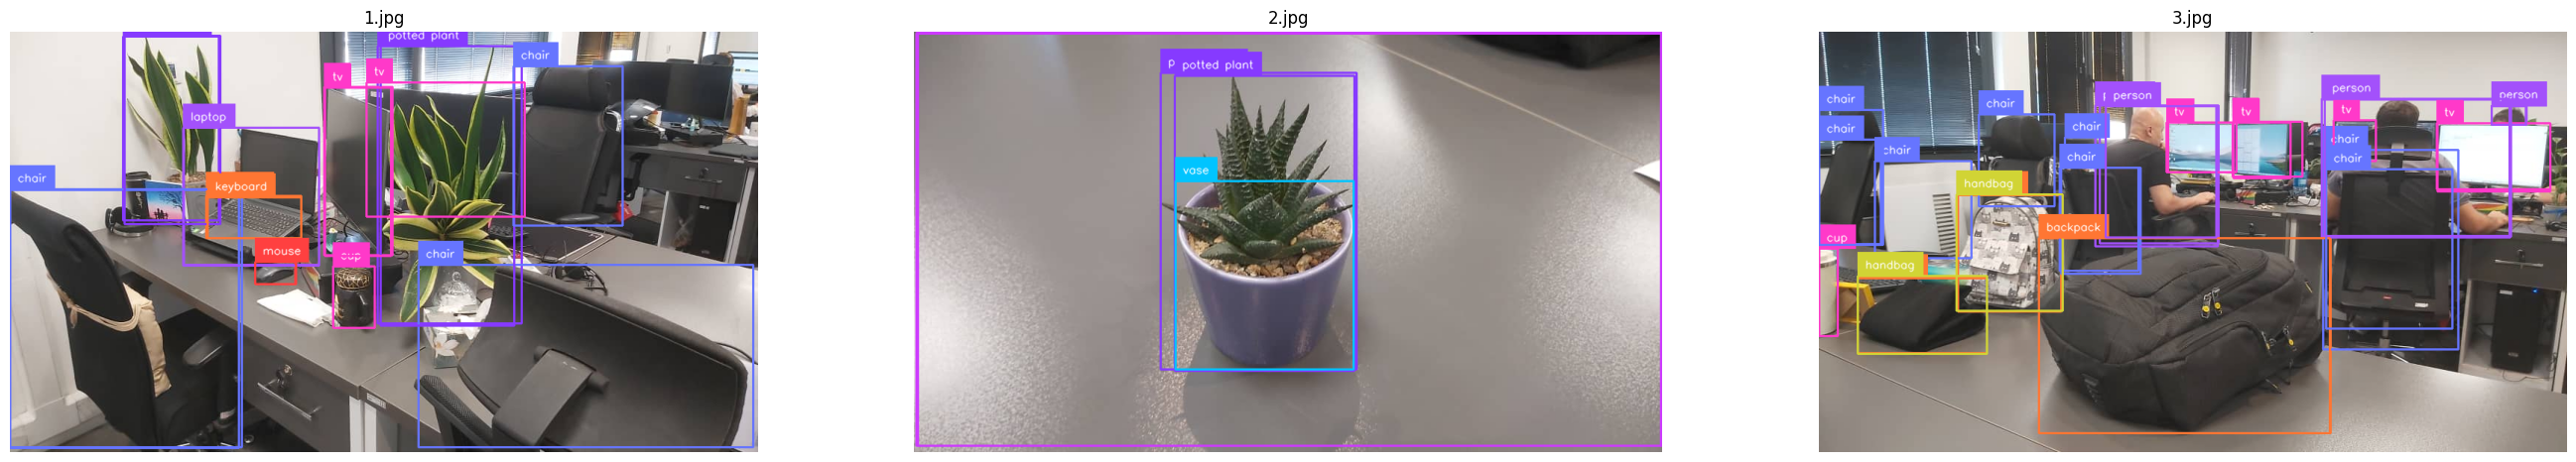

In [14]:
person_class , _ = detection(model12m, readed_images, [0])
person_detector = detector(person_class, readed_images)
plot_detection(person_detector)

In [15]:
person_class

[Detections(xyxy=array([], shape=(0, 4), dtype=float32), mask=None, confidence=array([], dtype=float32), class_id=array([], dtype=int64), tracker_id=None, data={'class_name': array([], dtype='<U12')}, metadata={}),
 Detections(xyxy=array([], shape=(0, 4), dtype=float32), mask=None, confidence=array([], dtype=float32), class_id=array([], dtype=int64), tracker_id=None, data={'class_name': array([], dtype='<U12')}, metadata={}),
 Detections(xyxy=array([[     386.01,      100.63,      535.65,      277.45],
        [     681.65,      90.412,      930.37,      275.25]], dtype=float32), mask=None, confidence=array([    0.85836,     0.82228], dtype=float32), class_id=array([0, 0]), tracker_id=None, data={'class_name': array(['person', 'person'], dtype='<U8')}, metadata={})]

In [16]:
# prediction = model.predict(
#     source=image1, 
#     save=True,
#     project ='./images',
#     exist_ok=True)
# prediction